The task is to use symbolic regression enabled by the gplearn to find mathematical formula correlating basic oxide perovskite properties tp OER activities. Dataset comes from: 
Weng, B., Song, Z., Zhu, R. et al. Simple descriptor derived from symbolic regression accelerating the discovery of new perovskite catalysts. Nat Commun 11, 3513 (2020).

In [1]:
import numpy as np
import pandas as pd
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
import openpyxl

Load and check the training set.

In [2]:
df = pd.read_excel("data_gp.xlsx")
X = df[['t', 'mu', 'RA', 'XA', 'XB', 'QA', 'Nd']].values
y = df['VRHE'].values

In [3]:
X

array([[0.993, 0.43 , 1.36 , 1.1  , 1.55 , 3.   , 4.   ],
       [0.998, 0.422, 1.36 , 1.1  , 1.73 , 3.   , 5.5  ],
       [1.003, 0.415, 1.36 , 1.1  , 1.91 , 3.   , 7.   ],
       [0.988, 0.437, 1.36 , 1.1  , 1.725, 3.   , 6.   ],
       [1.004, 0.414, 1.36 , 1.1  , 1.902, 3.   , 6.8  ],
       [1.004, 0.413, 1.36 , 1.1  , 1.894, 3.   , 6.6  ],
       [1.009, 0.407, 1.36 , 1.1  , 1.83 , 3.   , 5.   ],
       [1.01 , 0.407, 1.365, 1.115, 1.83 , 3.   , 5.   ],
       [1.012, 0.407, 1.37 , 1.13 , 1.83 , 3.   , 5.   ],
       [1.011, 0.404, 1.36 , 1.1  , 1.88 , 3.   , 6.   ],
       [1.011, 0.398, 1.35 , 1.05 , 1.88 , 2.5  , 5.5  ],
       [1.019, 0.401, 1.376, 1.07 , 1.88 , 2.8  , 5.8  ],
       [1.02 , 0.401, 1.38 , 1.063, 1.855, 2.75 , 5.25 ],
       [1.034, 0.397, 1.408, 1.01 , 1.88 , 2.4  , 5.4  ],
       [1.042, 0.395, 1.424, 0.98 , 1.88 , 2.2  , 5.2  ],
       [1.049, 0.393, 1.44 , 0.95 , 1.88 , 2.   , 5.   ],
       [1.082, 0.391, 1.525, 0.92 , 1.876, 2.   , 4.8  ],
       [1.119,

In [4]:
y

array([1.79158333, 1.72275   , 1.70783333, 1.77441667, 1.79083333,
       1.75391667, 1.75908333, 1.72466667, 1.75558333, 1.72058333,
       1.68158333, 1.6875    , 1.71858333, 1.69933333, 1.68025   ,
       1.67      , 1.63825   , 1.70916667])

The shape of X indicates there are 18 samples and each sample has 7 features. Before ftting, set a series of combinations of hyperparameters for symbolic regression.

In [ ]:
for pc in np.arange(0.875, 0.95, 0.025):
    for ps in np.arange((1-pc), (0.92-pc), -0.01):
        for parsimony in np.arange(0.0005, 0.0016, 0.0005):
            est_gp = SymbolicRegressor(population_size=5000, generations=20, stopping_criteria=0.01, p_crossover=pc, p_subtree_mutation=ps/3, 
            p_hoist_mutation=ps/3, p_point_mutation=1-pc-ps/3-ps/3, function_set=('add', 'sub', 'mul', 'div', 'sqrt'), 
            parsimony_coefficient=parsimony, tournament_size=20, metric='mean absolute error', const_range=(-1.0, 1.0))

            est_gp.fit(X, y)
            program = str(est_gp._program)
            length = est_gp._program.length_
            depth = est_gp._program.depth_
            y_pred = est_gp.predict(X)
            mae = mean_absolute_error(y, y_pred)

            with open("program_length_depth_mae.txt", "a") as f:
                f.write(f"pc: {pc}   ps: {ps}   ph: {ps}   pp: {1-pc-ps-ps}   p_coef: {parsimony}   {program}   length: {length}   depth: {depth}   mae: {mae}\n")

There are 18*8*3=432 combinations of (pc, ps, parsimony). For each combination, the training set will be fitted once, which results in one mathematical formula. So there will be 432 formulas generated. The hyperparameters, formula, length and depth of the formula and the mean absolute error (MAE) of that formula for the training set will be recorded in a file for each fit. In order to save time, I will just show the result of training, which is the program_length_depth_mae.txt file. For example, each fit will generate one formula with information including:

pc: xxx   ps: xxx   ph: xxx   pp: xxx   p_coef: xxx   formula   length: xxx   depth: xxx   mae: xxx

Next we need to sort these formulas based on the length and the depth.

In [ ]:
# Input and output file paths
input_file = "program_length_depth_mae.txt"
output_file_depth = "grouped_programs_depth.txt"
output_file_length = "grouped_programs_length.txt"

grouped_lines_length = defaultdict(list)
grouped_lines_depth = defaultdict(list)

# Read and group lines based on length
with open(input_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        key = parts[-5]
        grouped_lines_length[key].append(line)

# Read and group lines based on depth
with open(input_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        key = parts[-3]
        grouped_lines_depth[key].append(line)

# Sort lines based on the MAE value in each group
def extract_last_number(line):
    return float(line.strip().split()[-1])  # convert last token to float

for key in sorted(grouped_lines_length):
    grouped_lines_length[key] = sorted(grouped_lines_length[key], key=extract_last_number)

for key in sorted(grouped_lines_depth):
    grouped_lines_depth[key] = sorted(grouped_lines_depth[key], key=extract_last_number)

# Write grouped lines to output
with open(output_file_length, "w") as f:
    for key in sorted(grouped_lines_length):  # or just use grouped_lines if order doesn't matter
        f.writelines(grouped_lines_length[key])

with open(output_file_depth, "w") as f:
    for key in sorted(grouped_lines_depth):  # or just use grouped_lines if order doesn't matter
        f.writelines(grouped_lines_depth[key])

Formulas with the same number of length and depth will be grouped together, respectively, and then sorted in each group based on the MAE result of the formulas for the training set. Lastly, all the formulas will be stored in the files grouped_programs_length.txt (grouped by length) and grouped_programs_depth.txt (grouped by depth).

Lastly, plots the MAEs of all formulas with respect to formula length.

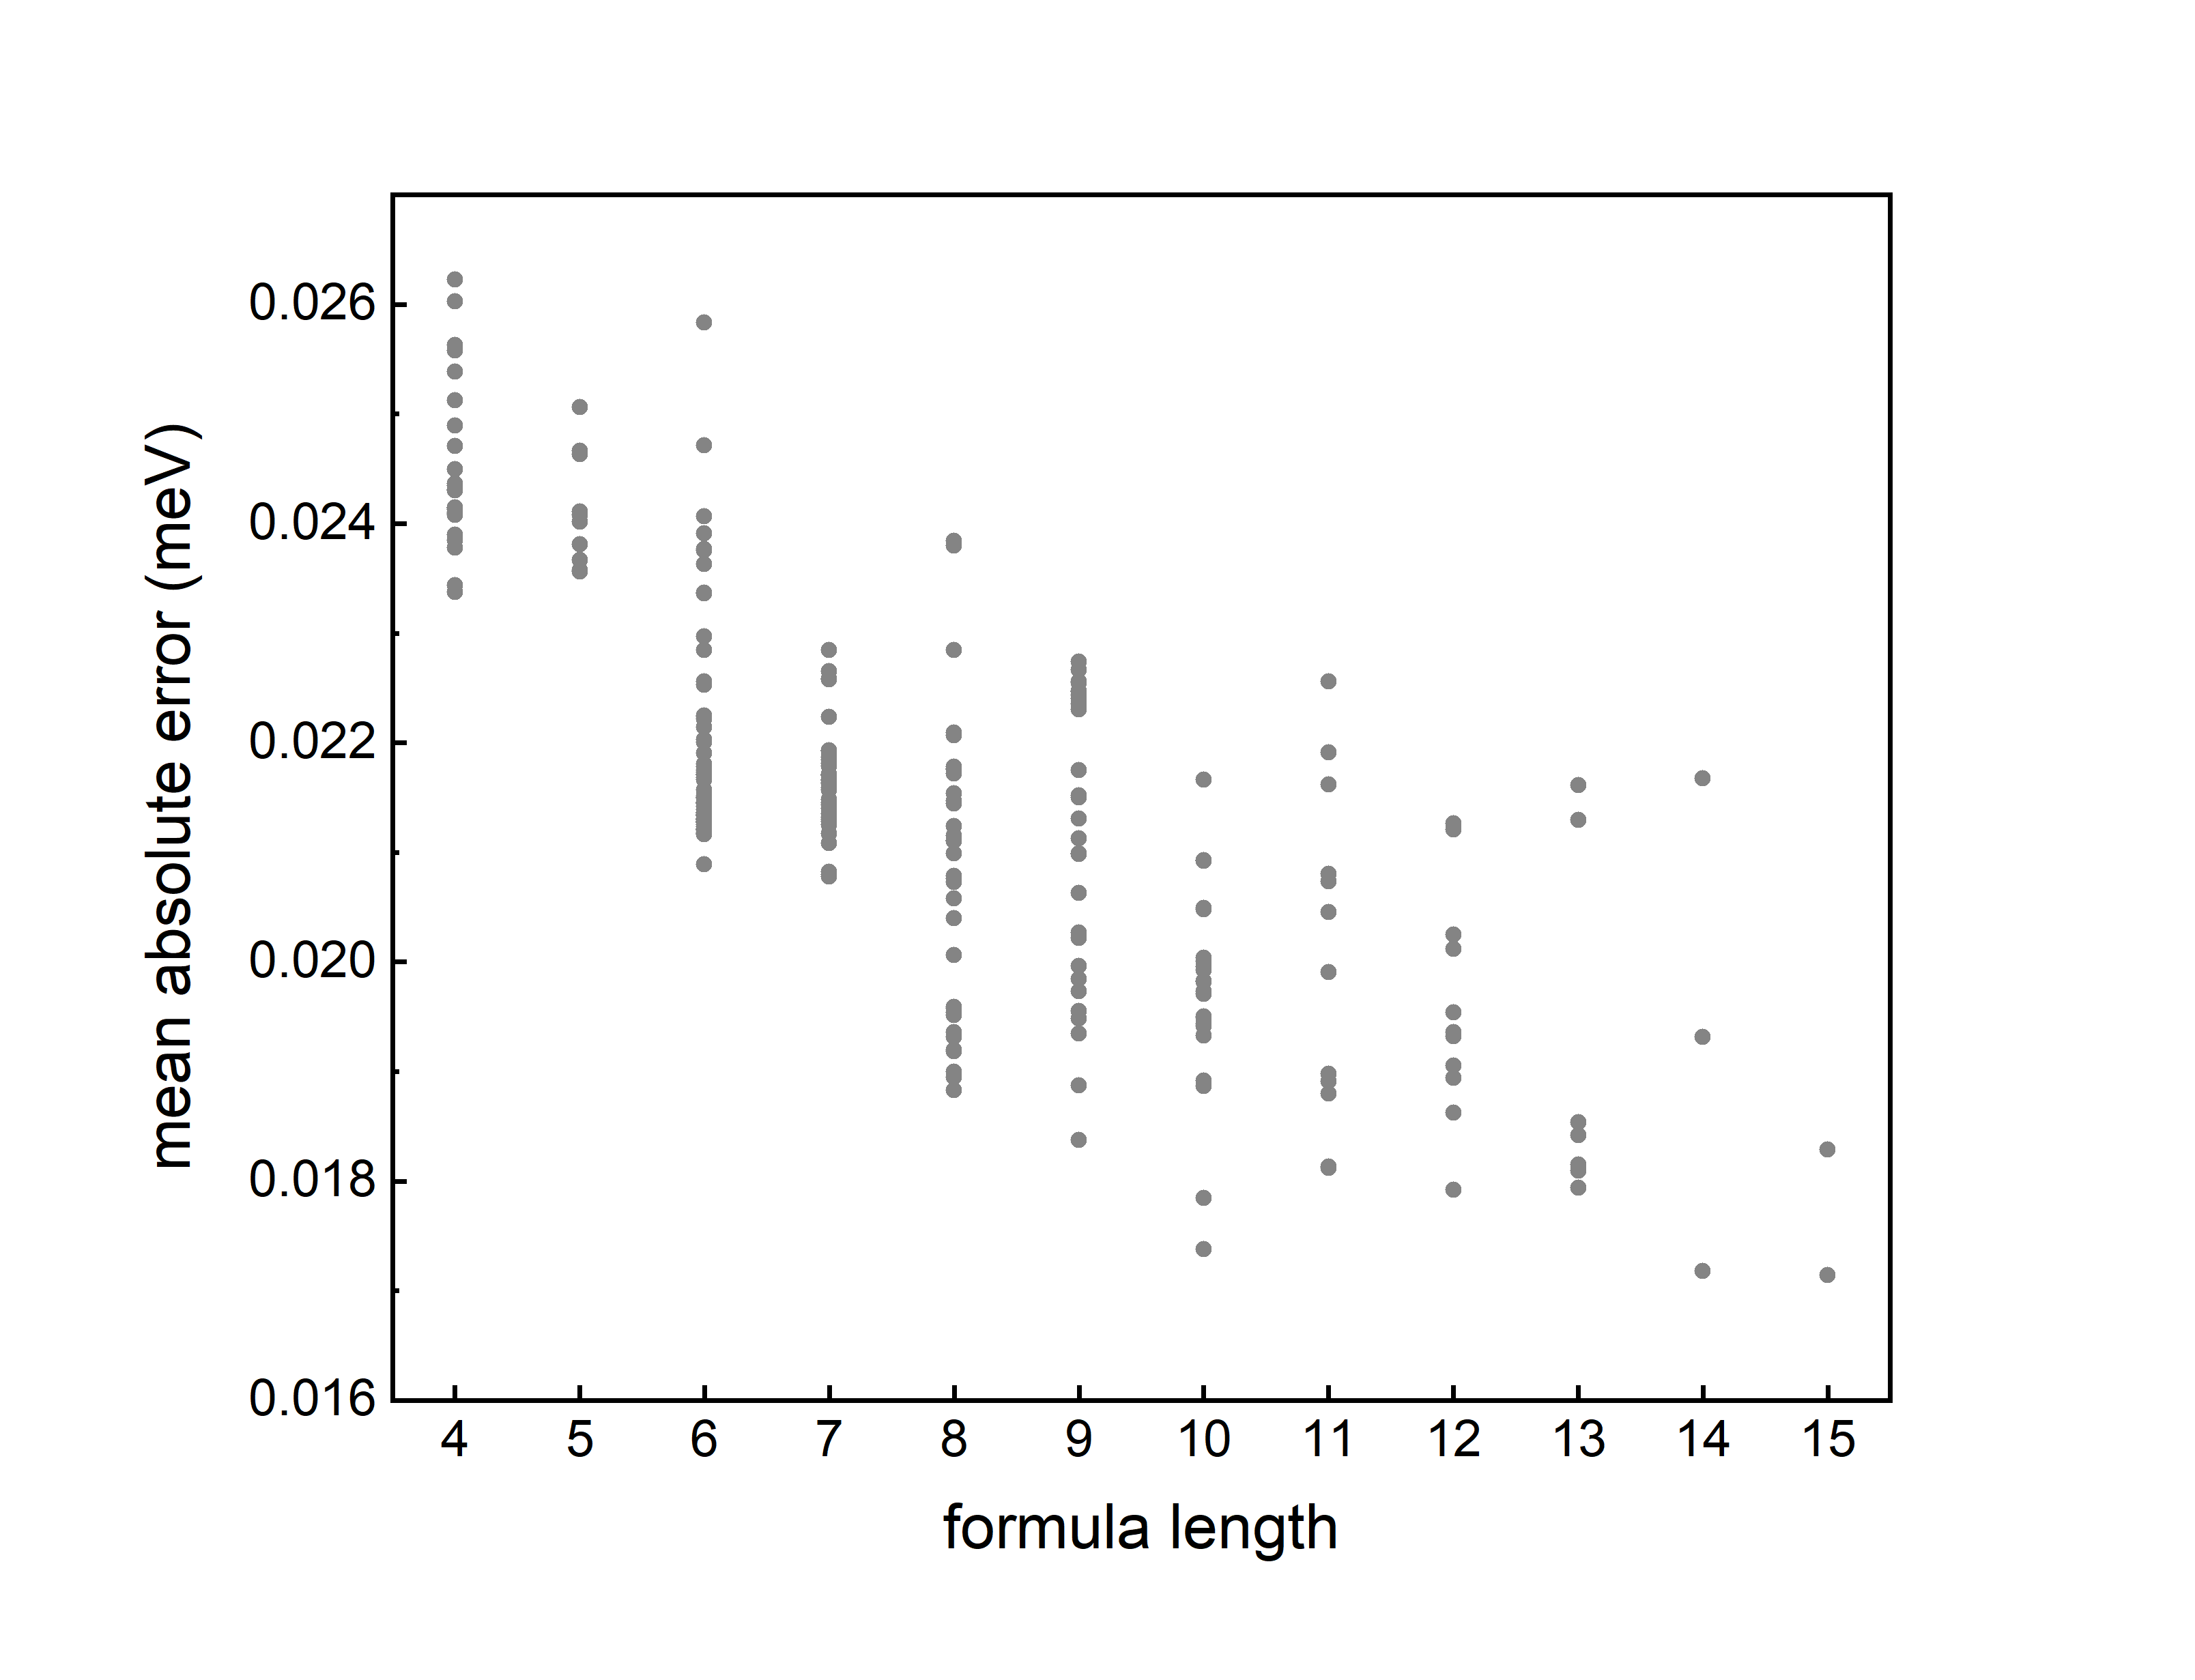

In [8]:
from IPython.display import Image

Image(filename='MAE_vs_length.png', width=500)